In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, jit, grad

key = jax.random.key(1234)

In [2]:
# Constants:
n_x = 2
n_u = 1
n_z = 1
DT = 0.01

In [3]:
# Vectorized rk4
def rk4(f, x, u):
    f = vmap(f, in_axes=(0,0))
    k1 = f(x          , u) 
    k2 = f(x + DT*k1/2, u)
    k3 = f(x + DT*k2/2, u)
    k4 = f(x + DT*k3  , u) 
    return x + (DT/6) * (k1 + 2*k2 + 2*k3 + k4)

In [4]:
# System dynamics 
def double_integrator(x, u):
    return jnp.array([x[1], u[0]])

In [5]:
# Generate random initial conditions
N_traj = int(3e4)
x = jax.random.normal(key, (N_traj, 2))
X = [x]

# Horizon
tf = 0.5
T = int(tf/DT)

# Evolve with random control inputs
rk4 = jax.jit(rk4, static_argnums=0)
keys = jax.random.split(key, T)
U = []
for t in range(T):
    u = 10*jax.random.normal(keys[t], (N_traj, 1))
    x = rk4(double_integrator, x, u)
    X.append(x)
    U.append(u)
    
X = jnp.array(X)
X = jnp.einsum('ijk->jik', X)

U = jnp.array(U)
U = jnp.einsum('ijk->jik', U)

print("X data shape", X.shape)
print("U data shape", U.shape)
filtered_inds = (jnp.abs(X[:,-1,0]) < jnp.abs(X[:,0,0])) * (jnp.abs(X[:,-1,1]) < jnp.abs(X[:,0,1]))
X = X[filtered_inds]
U = U[filtered_inds]
print("filtered X shape", X.shape)
print("filtered U shape", U.shape)

X data shape (30000, 51, 2)
U data shape (30000, 50, 1)
filtered X shape (4989, 51, 2)
filtered U shape (4989, 50, 1)


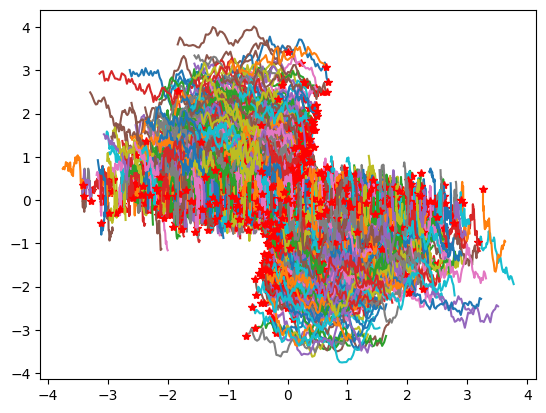

In [6]:
# Plot random stabilizing trajecotries
for i in range(X.shape[0]):
    plt.plot(X[i,:,0], X[i,:,1])
    plt.plot(X[i,-1,0], X[i,-1,1], 'r*')
plt.show()

In [8]:
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
from functools import partial
from jax import lax

In [9]:
class SimpleMLP(nn.Module):
    num_hidden: int
    num_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x) # prev. ReLU
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [10]:

# Create a subclass of TrainState to add a new metric
class CustomTrainState(train_state.TrainState):
    # You can add any other metric here, e.g., batch stats for BatchNorm
    loss: float

model_size = 16
# 1. Instantiate the model
encoder = SimpleMLP(num_hidden=model_size, num_outputs=n_z)
decoder = SimpleMLP(num_hidden=model_size, num_outputs=n_x)
fz = SimpleMLP(num_hidden=model_size, num_outputs=n_z)

enc_dummy_input = jnp.ones([1, n_x])
dec_dummy_input = jnp.ones([1, n_z])
fz_dummy_input = jnp.ones([1, n_z+n_u]) # Shape: (batch_size, num_features)


# 2. Initialize the model parameters
# We need to split the key for deterministic initialization
enc_init_key, dec_init_key, fz_init_key, enc_apply_key, dec_apply_key, fz_apply_key = jax.random.split(key, 6)
params_enc = encoder.init(enc_init_key, enc_dummy_input)['params']
params_dec = decoder.init(dec_init_key, dec_dummy_input)['params']
params_fz = fz.init(fz_init_key, fz_dummy_input)['params']

# 3. Define the optimizer
learning_rate = 1e-3
optimizer_enc = optax.adam(learning_rate)
optimizer_dec = optax.adam(learning_rate)
optimizer_fz = optax.adam(learning_rate)

# 4. Create the TrainState instance
enc_state = CustomTrainState.create(
    apply_fn=encoder.apply,
    params=params_enc,
    tx=optimizer_enc,
    loss=0.0 # Initialize our custom metric
)

dec_state = CustomTrainState.create(
    apply_fn=decoder.apply,
    params=params_dec,
    tx=optimizer_dec,
    loss=0.0 # Initialize our custom metric
)

fz_state = CustomTrainState.create(
    apply_fn=fz.apply,
    params=params_fz,
    tx=optimizer_fz,
    loss=0.0 # Initialize our custom metric
)


In [11]:

@jax.jit
def train_step(enc_state, dec_state, fz_state, batch):
    """A single JIT-compiled training step."""
    # Unpack the batch
    #inputs, targets = batch
    x_batch, U_batch = batch

    def _compute_rec_loss_single_trajectory(enc_params, dec_params, x, T):
        z = enc_state.apply_fn({'params' : enc_params}, x)
        x_rec = dec_state.apply_fn({'params' : dec_params}, z)
        rec_loss_per_traj = jnp.sum((x_rec - x)**2)
        #jax.debug.print("rec_loss per traj: {y}", y=rec_loss_per_traj)
        return rec_loss_per_traj / T
        
    def _compute_fwd_loss_single_trajectory(enc_params, fz_params, x, U, T): #, encoder, latent_dynamics_st):
        """
        Computes the total forward loss for a SINGLE trajectory.
        This function is designed to be vmapped over a batch of trajectories.
        The `latent_dynamics_step` argument is now a function that performs a single step.
        """
        # --- NEW: Pad U for fixed-size slicing ---
        # To handle the inner rollout scan, we need to slice a fixed number of controls.
        # We pad U with enough zeros so that we can always safely slice T-1 controls
        # from any starting point `k_idx`.
        U_padded = jnp.pad(U, ((0, T - 1), (0, 0)))
    
        # The outer loop of the loss is over the time horizon `t`.
        def t_loop_body(carry, t):
            fwd_loss_acc = carry
            
            # The inner loop over 'k' must have a fixed size for JIT compilation.
            # We loop over the maximum possible range of k and mask out invalid terms.
            k_indices = jnp.arange(T - 1) 
    
            def k_loop_body(k_idx):
                # This function computes the loss term for a single (k, t) pair.
                x_k = x[k_idx]
                x_k_plus_t = x[k_idx + t]
    
                # Encode initial and target states.
                z_k = enc_state.apply_fn({'params': enc_params}, x_k) #encoder(params, x_k)
                z_k_plus_t_target = enc_state.apply_fn({'params': enc_params}, x_k_plus_t)
    
                # --- MODIFIED ROLLOUT LOGIC ---
                # 1. Slice a STATIC shape from the padded controls. This is JIT-safe.
                U_slice_fixed = lax.dynamic_slice(U_padded, (k_idx, 0), (T - 1, U.shape[-1]))
    
                # 2. Define a rollout step that masks its own update.
                def rollout_step(carry_z, u_and_idx):
                    u_t_slice, step_idx = u_and_idx
                    # Perform the dynamics update unconditionally.
                    #next_z = latent_dynamics_step(params, carry_z, u_t_slice)
                    next_z = fz_state.apply_fn({'params': enc_params}, jnp.concat([carry_z, u_t_slice]))
                    
                    # Conditionally select the next state using `where`.
                    # If step_idx < t, we use the new state. Otherwise, we keep the old one.
                    # This effectively stops the rollout after `t` steps.
                    updated_z = jnp.where(step_idx < t, next_z, carry_z)
                    
                    return updated_z, None 
    
                # 3. Scan over the fixed-size slice and an index array.
                scan_xs = (U_slice_fixed, jnp.arange(T - 1))
                z_k_plus_t_pred, _ = lax.scan(rollout_step, z_k, scan_xs)
                
                fwd_term = jnp.sum((z_k_plus_t_target - z_k_plus_t_pred)**2)
    
                # --- MASKING LOGIC for 'k' loop (from previous fix) ---
                is_valid_k = k_idx < (T - t)
                return jnp.where(is_valid_k, fwd_term, 0.0)
    
            # Vmap the inner function over the FIXED range of k_indices.
            fwd_terms = jax.vmap(k_loop_body)(k_indices)
            fwd_loss_acc += jnp.sum(fwd_terms)
            return fwd_loss_acc, None
    
        initial_carry = 0.0
        t_values = jnp.arange(1, T)
        total_fwd_loss, _ = lax.scan(t_loop_body, initial_carry, t_values)
        #jax.debug.print("fwd_loss per traj: {y}", y=total_fwd_loss)
        return total_fwd_loss

    @partial(jax.jit, static_argnames=('T',))
    def loss_fn(enc_params, dec_params, fz_params, T): #, x_batch, U_batch, encoder, latent_dynamics_step):
        """
        Computes the total jittable forward loss for a batch of trajectories.
        Corresponds to the L_fwd equation.
        The `latent_dynamics_step` argument has been updated.
        """
        N, _, _ = x_batch.shape
        
        single_fwd_loss_fn = partial(_compute_fwd_loss_single_trajectory, T=T)
        single_rec_loss_fn = partial(_compute_rec_loss_single_trajectory, T=T)
    
        #fwd_losses = jax.vmap(
        #    single_loss_fn, in_axes=(None, 0, 0, None, None)
        #)(params, x_batch, U_batch, encoder, latent_dynamics_step)
        fwd_losses = jax.vmap(
            single_fwd_loss_fn, in_axes=(None, None, 0, 0)
        )(enc_params, fz_params, x_batch, U_batch)

        rec_losses = jax.vmap(
            single_rec_loss_fn, in_axes=(None, None, 0)
        )(enc_params, dec_params, x_batch) 
        #jax.debug.print("total loss: {y}", y=jnp.sum(fwd_losses) + jnp.sum(rec_losses))
        return (1/N) * (jnp.sum(fwd_losses) + jnp.sum(rec_losses))

    # Use jax.grad to get the gradient function
    # The 'has_aux=False' means the loss_fn only returns one value (the loss).
    # If it returned more (e.g., loss, accuracy), you'd use has_aux=True.
    grad_fn = jax.value_and_grad(loss_fn, argnums=(0, 1, 2))
    loss, grads = grad_fn(enc_state.params, dec_state.params, fz_state.params, T)
    #jax.debug.print("loss outside: {y}", y=loss)

    # Use state.apply_gradients to update the parameters and optimizer state
    # This automatically handles the optimizer logic (e.g., Adam updates)
    enc_state = enc_state.apply_gradients(grads=grads[0])
    dec_state = dec_state.apply_gradients(grads=grads[1])
    fz_state = fz_state.apply_gradients(grads=grads[2])
    
    # We can also update our custom metrics in the state
    enc_state = enc_state.replace(loss=loss)
    dec_state = dec_state.replace(loss=loss)
    fz_state = fz_state.replace(loss=loss)
    
    return enc_state, dec_state, fz_state
    

In [12]:

# Generate some dummy data for training
'''
num_samples = 1000
num_features = 10
X = np.random.rand(num_samples, num_features)
# A simple linear relationship for the target
y = X @ np.random.rand(num_features, 1) + 0.5
'''
num_samples = X.shape[0] 

# --- Training Loop ---
num_epochs = 500
batch_size = 256
num_steps_per_epoch = num_samples // batch_size

print("Starting training...")
for epoch in range(num_epochs):
    # Simple data shuffling
    perm = np.random.permutation(num_samples)
    #X_shuffled, y_shuffled = X[perm], y[perm]
    X_shuffled, U_shuffled = X[perm], U[perm]

    for step in range(num_steps_per_epoch):
        # Create a batch
        start_idx = step * batch_size
        end_idx = start_idx + batch_size
        batch = (X_shuffled[start_idx:end_idx], U_shuffled[start_idx:end_idx])

        # Execute the training step
        enc_state, dec_state, fz_state = train_step(enc_state, dec_state, fz_state, batch) # state is updated here!

    # Print the loss from the last step of the epoch
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {enc_state.loss:.4f}")
    
print("Training finished.")


Starting training...
Epoch 0, Loss: 31.7182
Epoch 20, Loss: 2.2830
Epoch 40, Loss: 1.5817
Epoch 60, Loss: 1.5666
Epoch 80, Loss: 1.7789
Epoch 100, Loss: 1.5727
Epoch 120, Loss: 1.1890
Epoch 140, Loss: 0.7998
Epoch 160, Loss: 0.6197
Epoch 180, Loss: 0.5760
Epoch 200, Loss: 0.5068
Epoch 220, Loss: 0.5504
Epoch 240, Loss: 0.4140
Epoch 260, Loss: 0.5008
Epoch 280, Loss: 0.4778
Epoch 300, Loss: 0.4011
Epoch 320, Loss: 0.4891
Epoch 340, Loss: 0.4233
Epoch 360, Loss: 0.4288
Epoch 380, Loss: 0.4354
Epoch 400, Loss: 0.3810
Epoch 420, Loss: 0.4239
Epoch 440, Loss: 0.4039
Epoch 460, Loss: 0.4967
Epoch 480, Loss: 0.4337
Training finished.
